In [ ]:
#Load the Project 1. Results - Excel Files

In [ ]:
import os
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


training_sizes = ['100', '375', '650', '815', '1035', '1325', '2200', '3500', '6500', '15000']


folders = {
    "without_momentum": os.path.expanduser("~/Project 1./Baseline_ANN_without_momentum_results"),
    "with_momentum": os.path.expanduser("~/Project 1./Baseline_ANN_with_momentum_results"),
    "expanded_adam": os.path.expanduser("~/Project 1./Expanded_ANN_Adam_results"),
    "expanded_sgd": os.path.expanduser("~/Project 1./Expanded_ANN_SGD_results")
}


data = {}
for key in folders.keys():
    data[key] = {
        "mse_train": [], "mse_test": [],
        "mae_train": [], "mae_test": []
    }


def load_excel_metrics(folder, container):
    for size in training_sizes:
        file_path = os.path.join(folder, f"_{size}.xlsx")
        if not os.path.exists(file_path):
            print(f"Missing file: {file_path}")
            for lst in container.values():
                lst.append(np.nan)
            continue

        try:
            df = pd.read_excel(file_path, sheet_name="Metrics Summary")
        except Exception as e:
            print(f"Could not read {file_path}: {e}")
            for lst in container.values():
                lst.append(np.nan)
            continue

        df.columns = [re.sub(r'[^a-z0-9]+', '_', c.lower().strip()) for c in df.columns]

        dataset_col = next((c for c in df.columns if "dataset" in c), None)
        if dataset_col is None:
            print(f"Could not find dataset column in {file_path}")
            for lst in container.values():
                lst.append(np.nan)
            continue

        df[dataset_col] = df[dataset_col].astype(str).str.lower().str.strip()

        try:
            train_row = df[df[dataset_col].str.contains("train", na=False)].iloc[0]
            test_row  = df[df[dataset_col].str.contains("test", na=False)].iloc[0]
        except IndexError:
            print(f"Train/Test rows missing in {file_path}")
            for lst in container.values():
                lst.append(np.nan)
            continue

        container["mse_train"].append(float(train_row.get("mse", np.nan)))
        container["mse_test"].append(float(test_row.get("mse", np.nan)))
        container["mae_train"].append(float(train_row.get("mae", np.nan)))
        container["mae_test"].append(float(test_row.get("mae", np.nan)))

        print(f"{size:>5} → MSE(train/test): {container['mse_train'][-1]:.4f}/{container['mse_test'][-1]:.4f}, "
              f"MAE(train/test): {container['mae_train'][-1]:.4f}/{container['mae_test'][-1]:.4f}")


for key, folder in folders.items():
    print(f"\nLoading metrics for {key}...")
    load_excel_metrics(folder, data[key])

print("\n All Excel metrics loaded successfully!\n")






Loading metrics for without_momentum...
  100 → MSE(train/test): 0.6730/1.9681, MAE(train/test): 0.5477/0.9147
  375 → MSE(train/test): 0.9162/1.2317, MAE(train/test): 0.6968/0.7131
  650 → MSE(train/test): 0.8824/1.0483, MAE(train/test): 0.6936/0.6921
  815 → MSE(train/test): 0.9936/1.0443, MAE(train/test): 0.7232/0.7171
 1035 → MSE(train/test): 0.9175/1.1730, MAE(train/test): 0.6793/0.7604
 1325 → MSE(train/test): 0.8777/1.0335, MAE(train/test): 0.6846/0.6683
 2200 → MSE(train/test): 0.9280/1.0523, MAE(train/test): 0.6956/0.7210
 3500 → MSE(train/test): 1.0143/1.0078, MAE(train/test): 0.7259/0.7116
 6500 → MSE(train/test): 0.9133/1.0185, MAE(train/test): 0.6940/0.6856
15000 → MSE(train/test): 0.9449/0.9389, MAE(train/test): 0.7007/0.6936

Loading metrics for with_momentum...
  100 → MSE(train/test): 0.0240/0.5549, MAE(train/test): 0.1019/0.3826
  375 → MSE(train/test): 0.0864/0.3367, MAE(train/test): 0.1992/0.2754
  650 → MSE(train/test): 0.1005/0.2466, MAE(train/test): 0.2105/0.254

In [ ]:
#Heatmaps for Project 1.

Exported CSV: Heatmap_Results/Project_1_MeanSquaredErrorMSE_metrics.csv


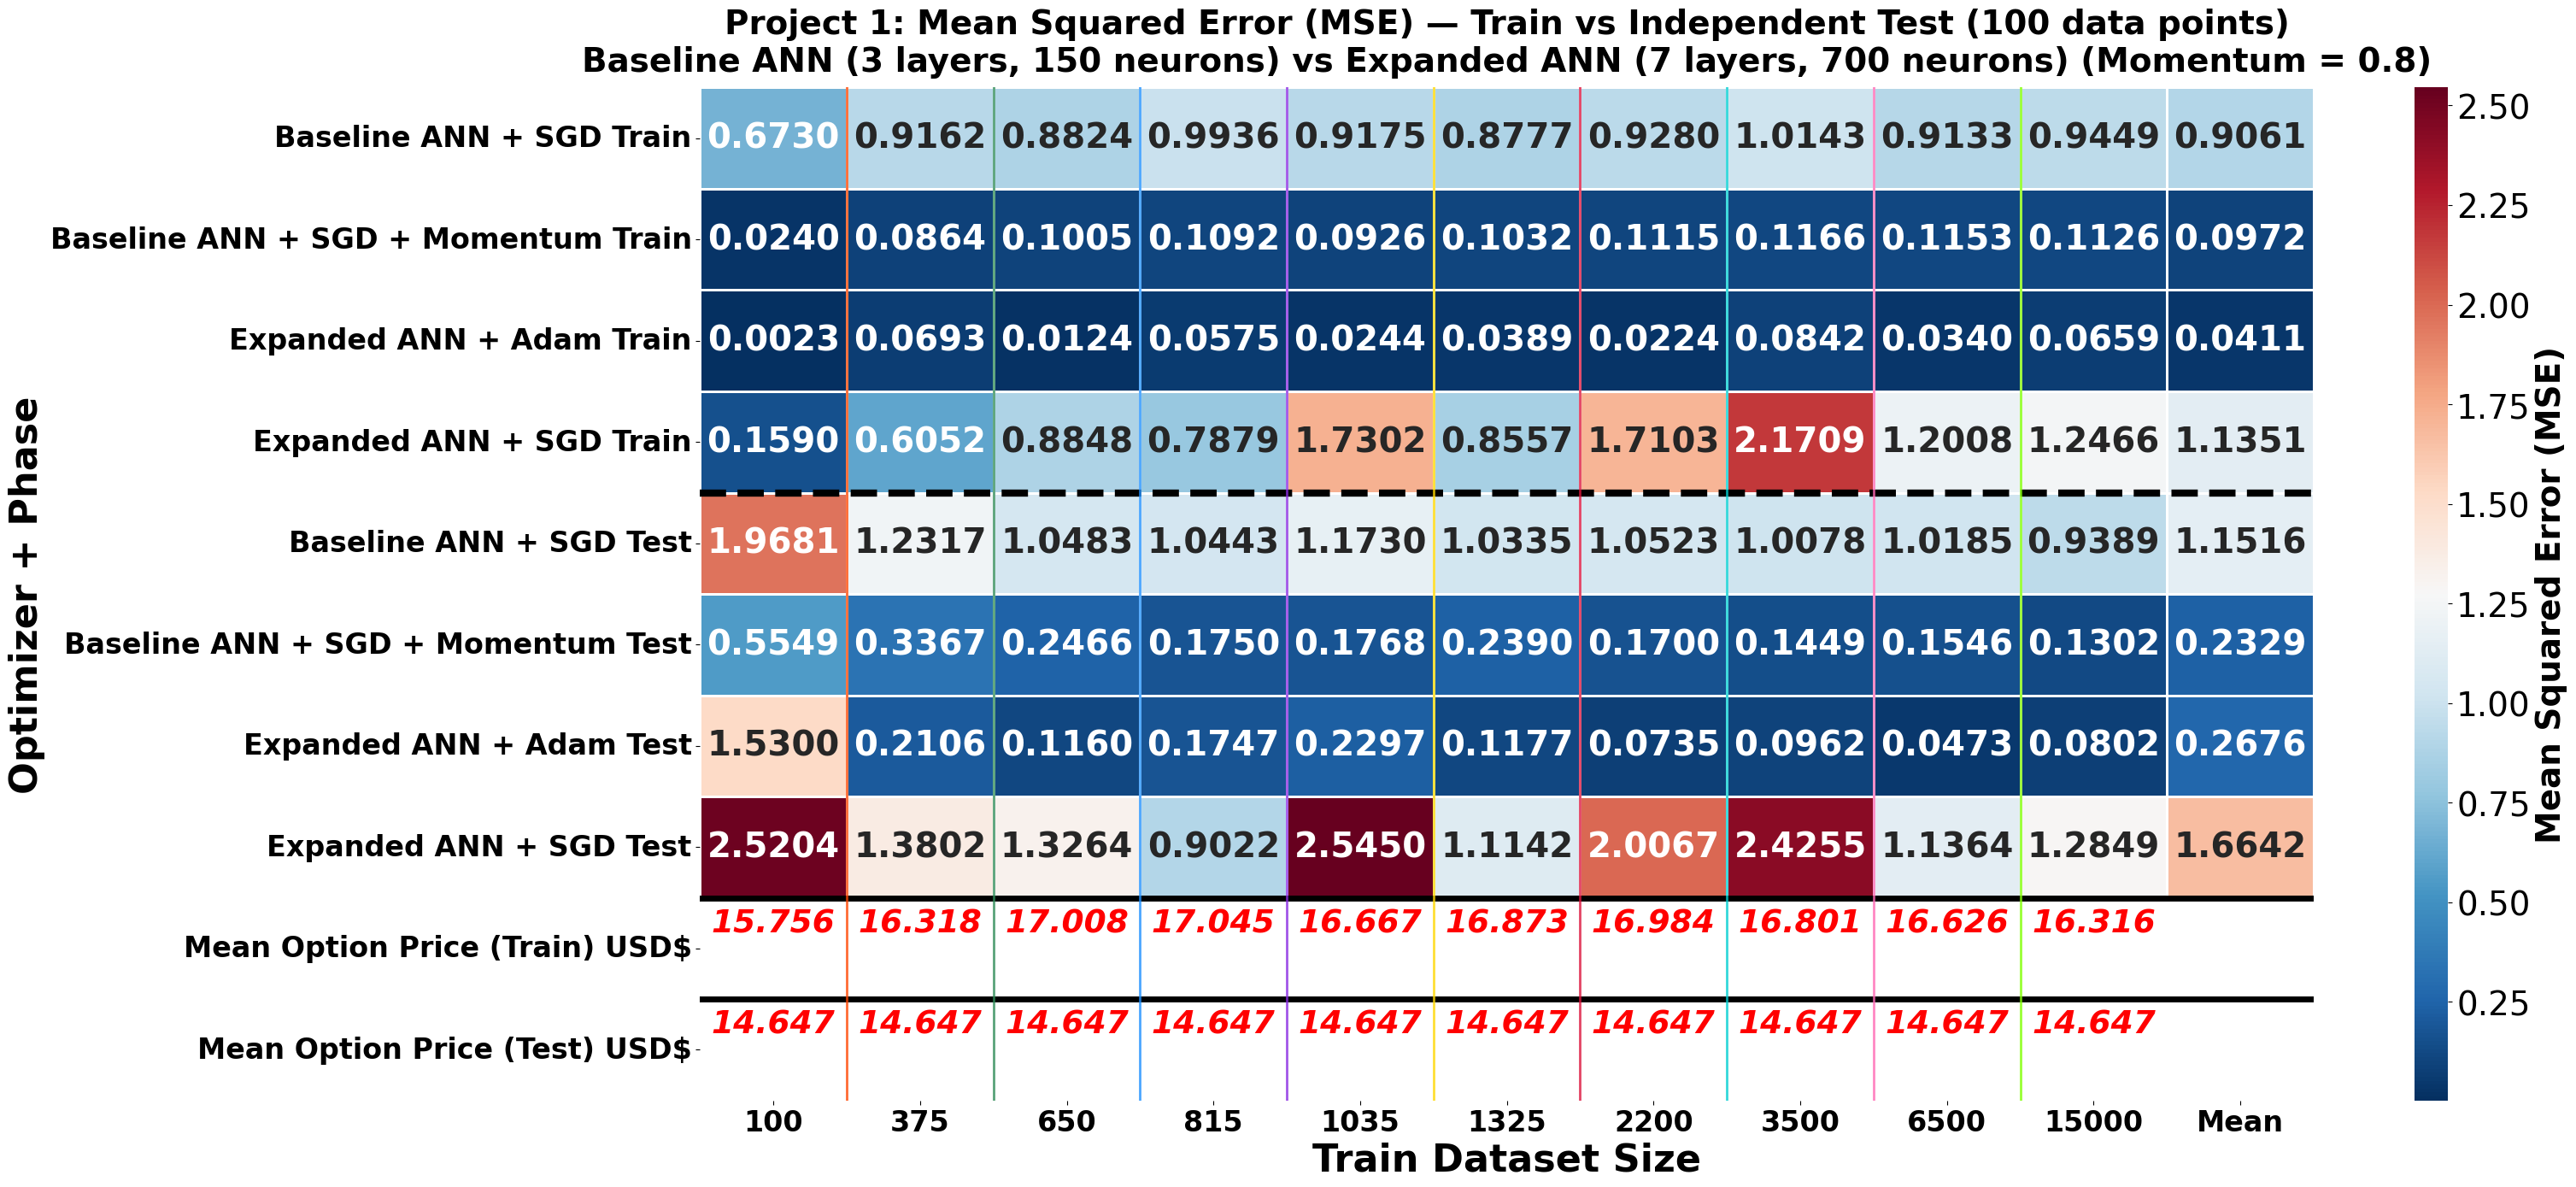

Saved heatmap: Heatmap_Results/Project_1_MeanSquaredErrorMSE_heatmap.pdf
Exported CSV: Heatmap_Results/Project_1_MeanAbsoluteErrorMAEUSD_metrics.csv


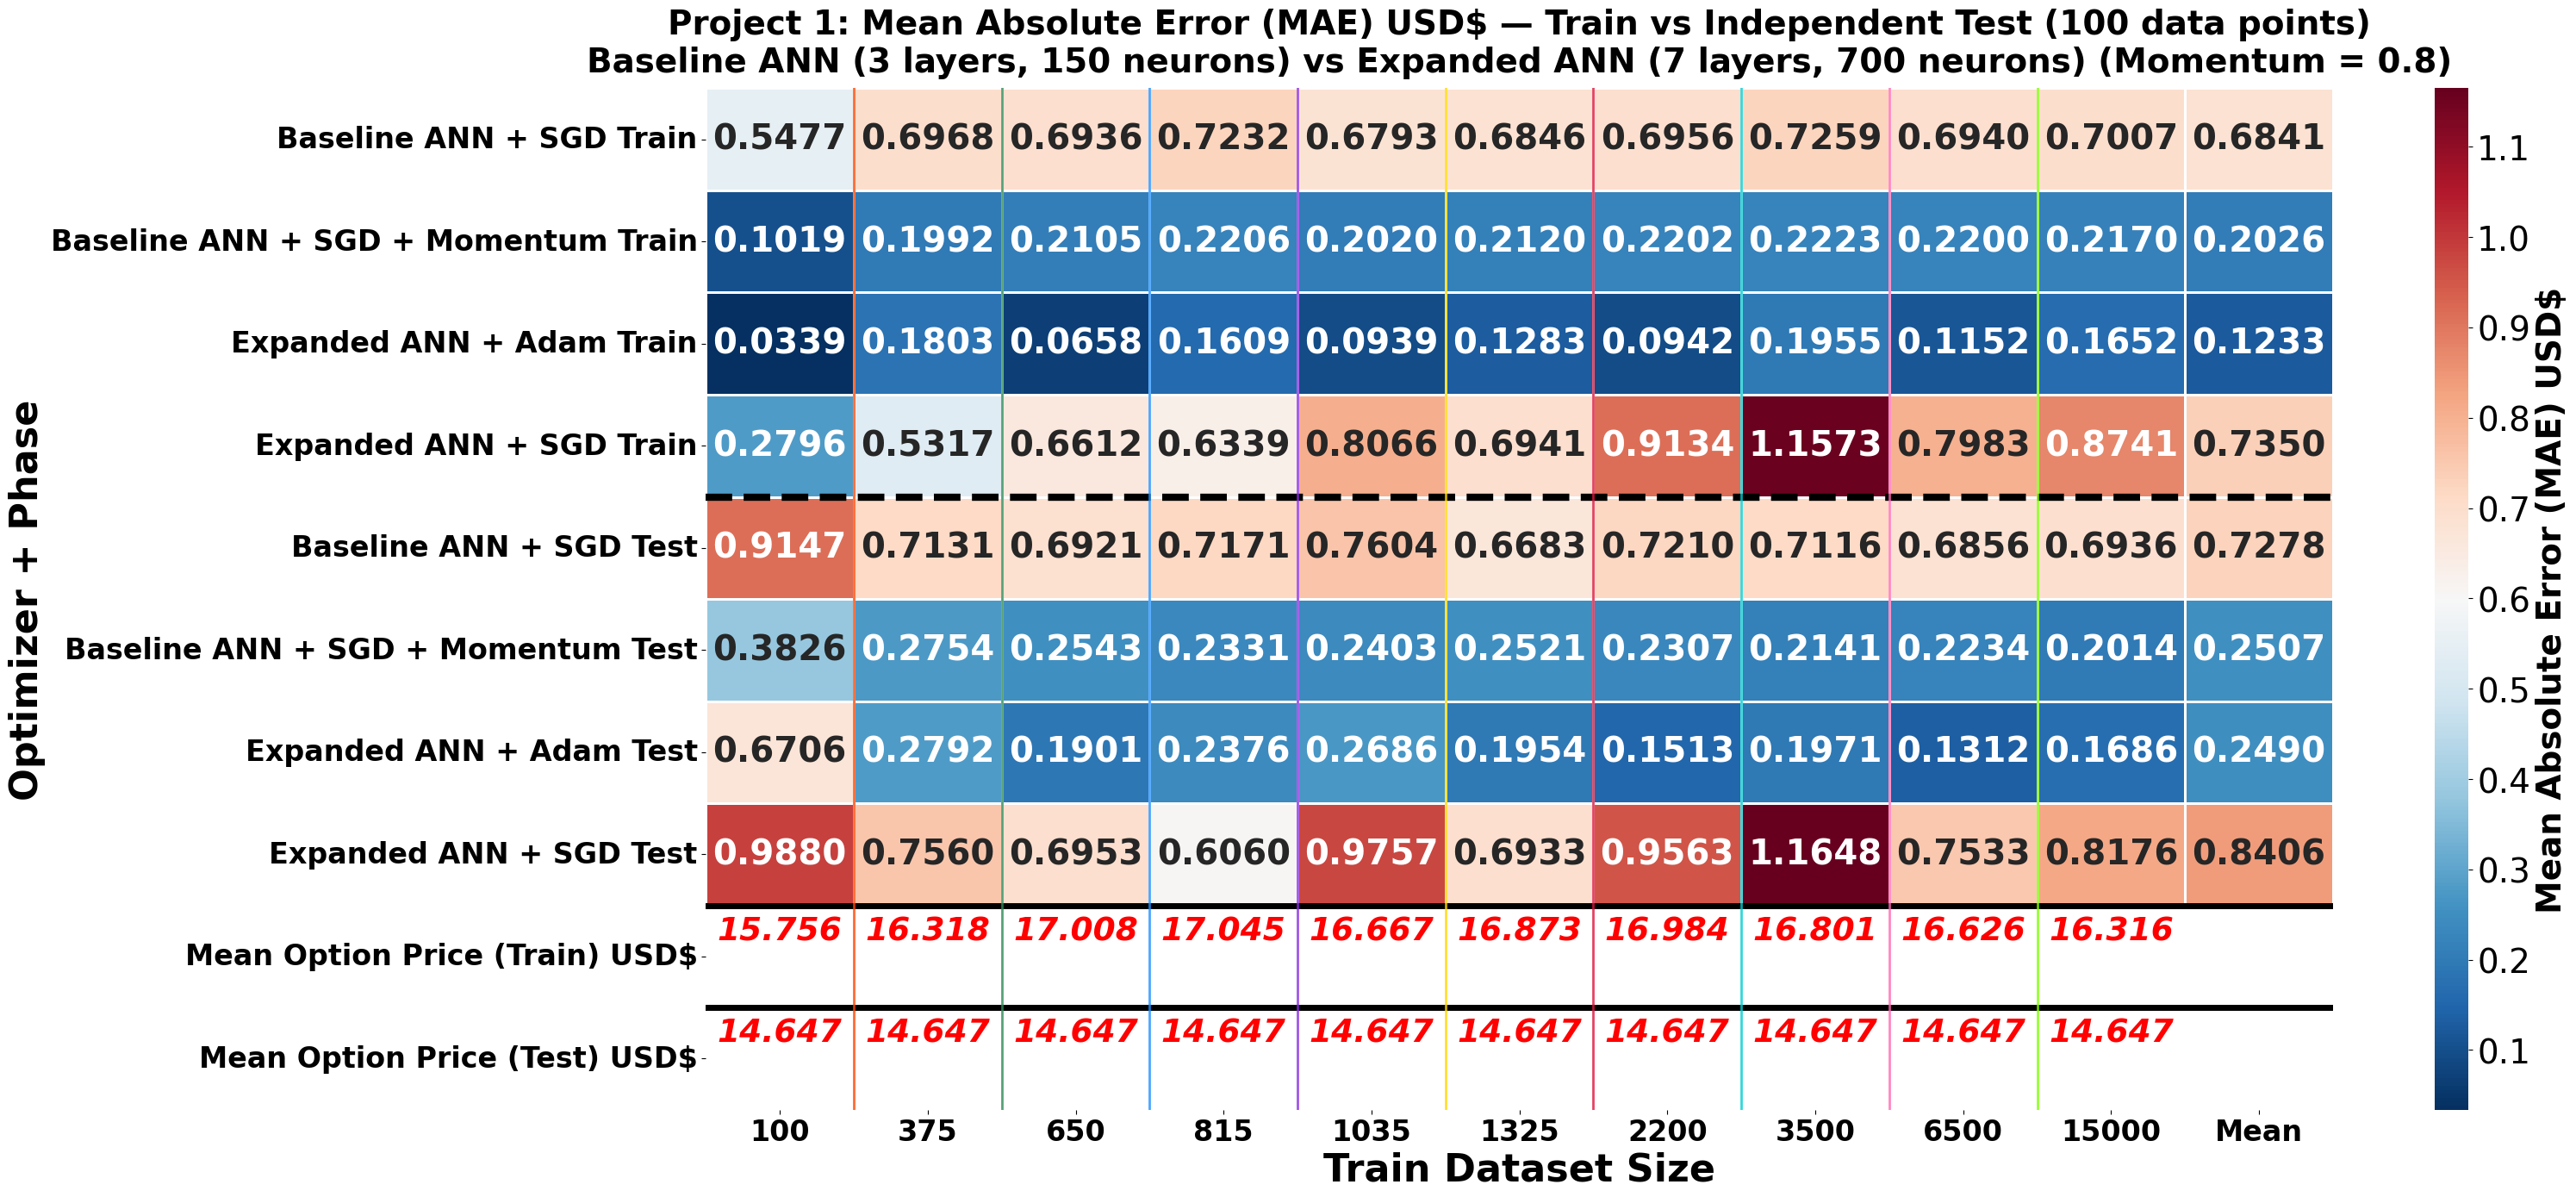

Saved heatmap: Heatmap_Results/Project_1_MeanAbsoluteErrorMAEUSD_heatmap.pdf
Exported CSV: Heatmap_Results/Project_1_MAEMeanOptionPrice_metrics.csv


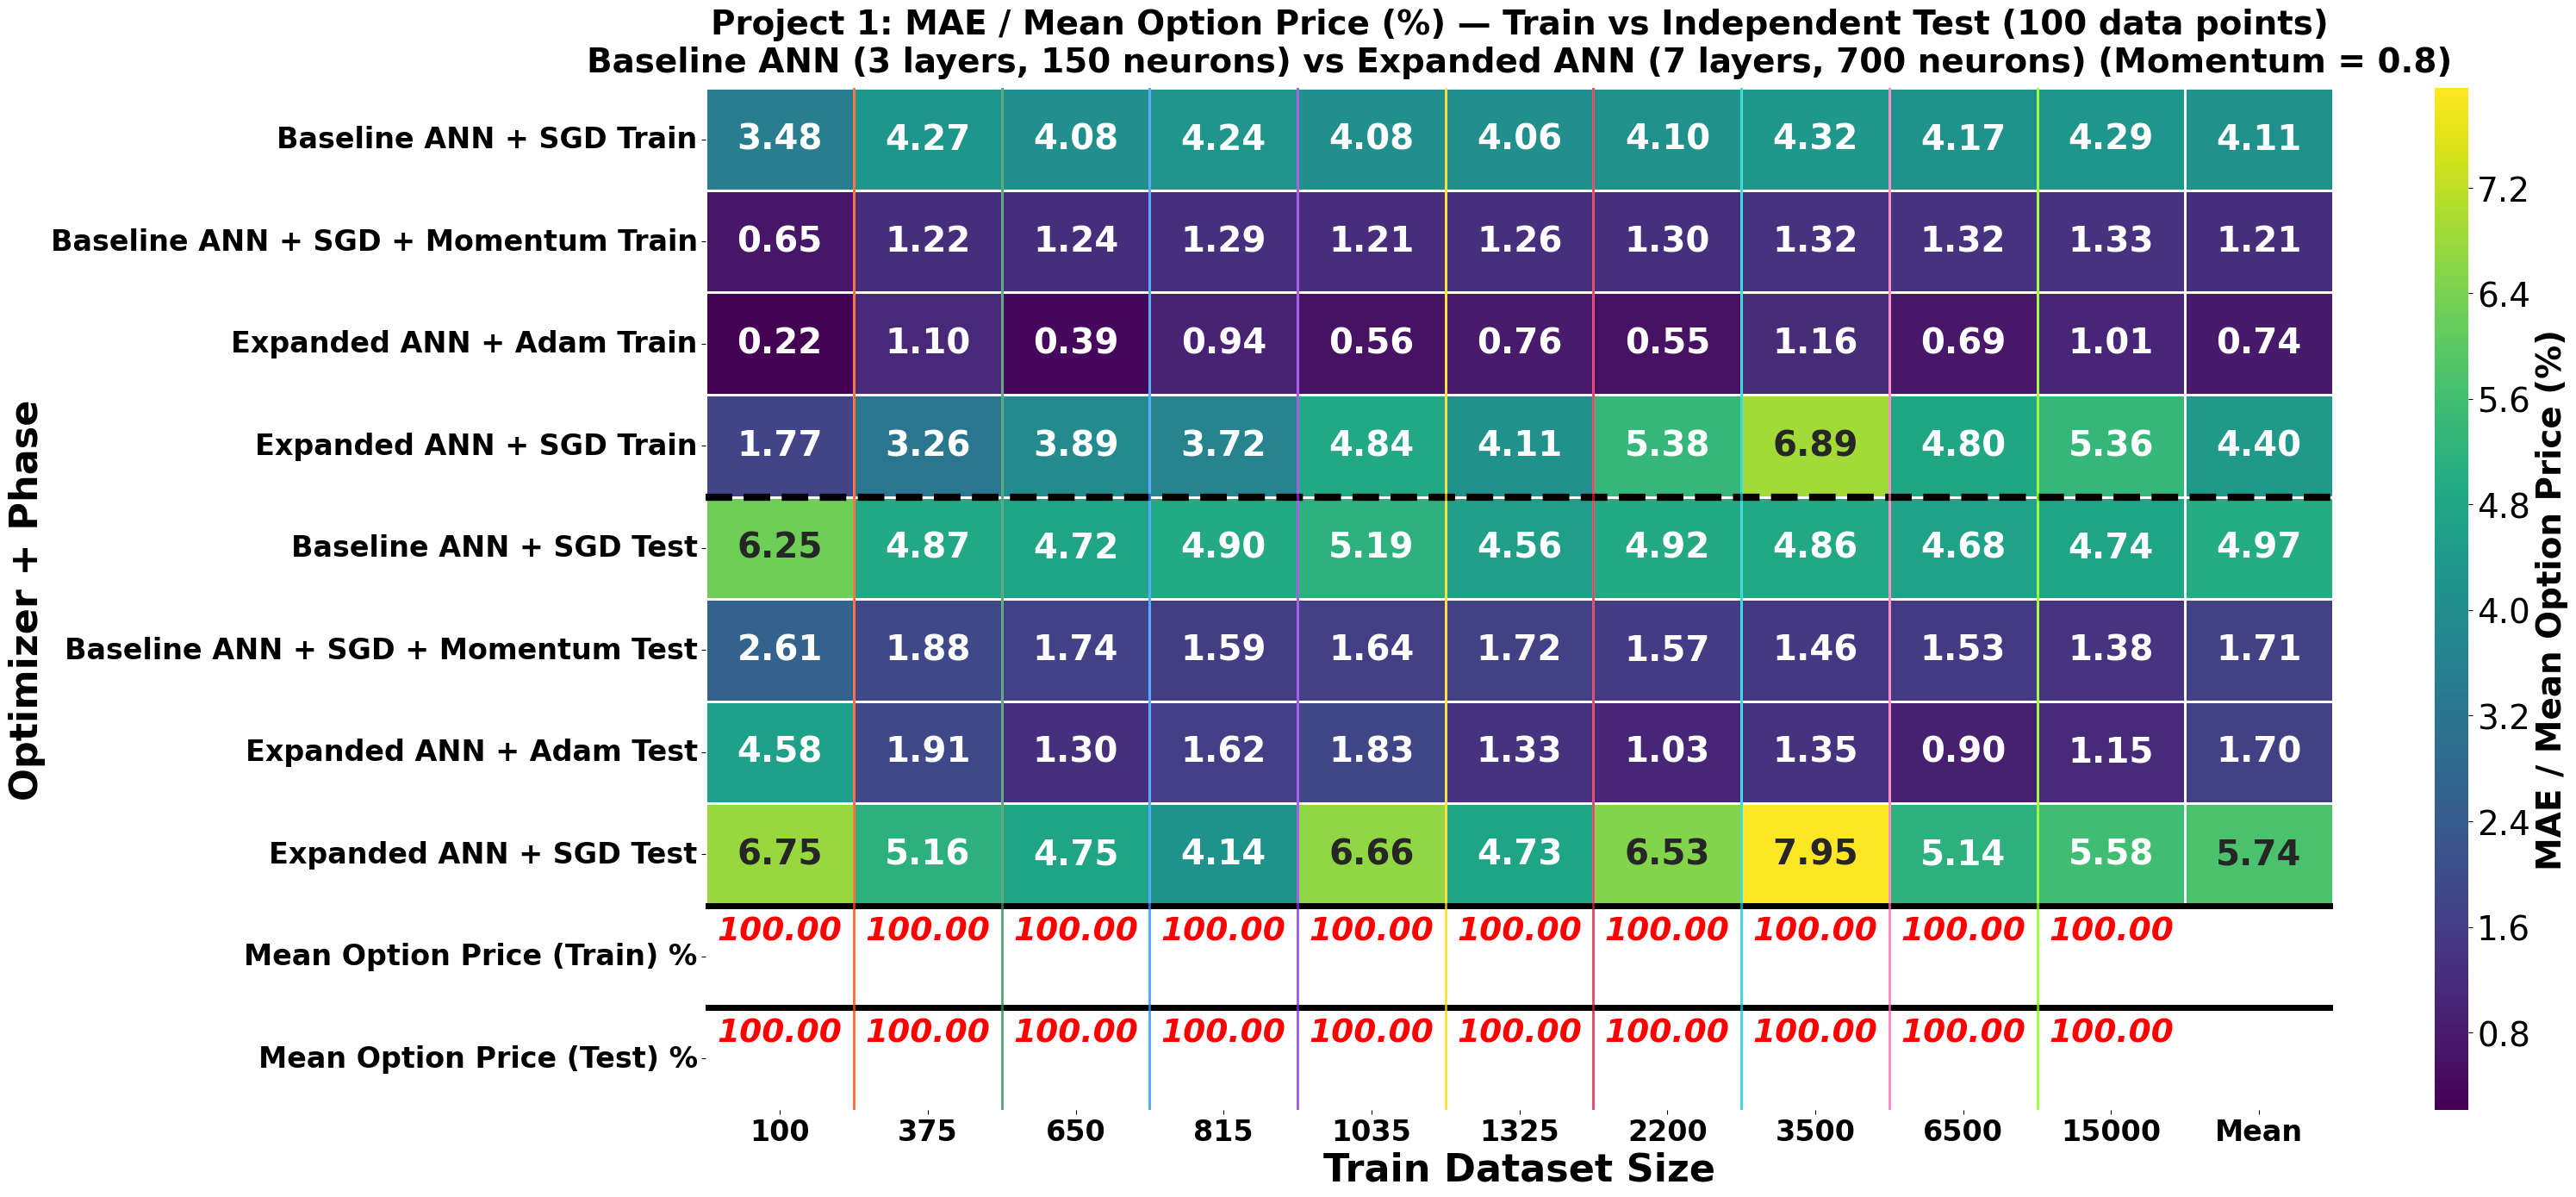

Saved heatmap: Heatmap_Results/Project_1_maemop_heatmap.pdf


In [4]:
def plot_combined_heatmap(metric_name,
                          data_dict,
                          metric_key,
                          training_sizes,
                          cmap=None,
                          center=None,
                          as_percentage=False):
    """
    Plots a combined heatmap for Baseline and Expanded ANNs and
    exports metrics and mean option prices to CSV files.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.ticker import MaxNLocator
    import os

    # ---- Load mean option prices from CSVs ----
    def load_mean_prices(file_path):
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
        return df["mean_option_price"].tolist()

    mean_train = load_mean_prices("mean_option_price_train.csv")
    mean_test  = load_mean_prices("mean_option_price_test.csv")

    def repeat_test_values(test_list):
        if len(test_list) == 1:
            return test_list * len(training_sizes)
        return test_list

    # ---- Extract metrics ----
    baseline_sgd_train = data_dict["without_momentum"][f"{metric_key}_train"]
    baseline_sgd_test  = repeat_test_values(data_dict["without_momentum"][f"{metric_key}_test"])
    baseline_mom_train = data_dict["with_momentum"][f"{metric_key}_train"]
    baseline_mom_test  = repeat_test_values(data_dict["with_momentum"][f"{metric_key}_test"])
    expanded_adam_train = data_dict["expanded_adam"][f"{metric_key}_train"]
    expanded_adam_test  = repeat_test_values(data_dict["expanded_adam"][f"{metric_key}_test"])
    expanded_sgd_train  = data_dict["expanded_sgd"][f"{metric_key}_train"]
    expanded_sgd_test   = repeat_test_values(data_dict["expanded_sgd"][f"{metric_key}_test"])

    if as_percentage:
        baseline_sgd_train = [v/m*100 for v,m in zip(baseline_sgd_train, mean_train)]
        baseline_mom_train = [v/m*100 for v,m in zip(baseline_mom_train, mean_train)]
        expanded_adam_train = [v/m*100 for v,m in zip(expanded_adam_train, mean_train)]
        expanded_sgd_train = [v/m*100 for v,m in zip(expanded_sgd_train, mean_train)]

        baseline_sgd_test  = [v/mean_test[0]*100 for v in baseline_sgd_test]
        baseline_mom_test  = [v/mean_test[0]*100 for v in baseline_mom_test]
        expanded_adam_test = [v/mean_test[0]*100 for v in expanded_adam_test]
        expanded_sgd_test  = [v/mean_test[0]*100 for v in expanded_sgd_test]

    df_train = pd.DataFrame(
        [
            baseline_sgd_train,
            baseline_mom_train,
            expanded_adam_train,
            expanded_sgd_train
        ],
        index=[
            "Baseline ANN + SGD Train",
            "Baseline ANN + SGD + Momentum Train",
            "Expanded ANN + Adam Train",
            "Expanded ANN + SGD Train"
        ],
        columns=training_sizes
    )

    df_test = pd.DataFrame(
        [
            baseline_sgd_test,
            baseline_mom_test,
            expanded_adam_test,
            expanded_sgd_test
        ],
        index=[
            "Baseline ANN + SGD Test",
            "Baseline ANN + SGD + Momentum Test",
            "Expanded ANN + Adam Test",
            "Expanded ANN + SGD Test"
        ],
        columns=training_sizes
    )

    df = pd.concat([df_train, df_test])
    df["Mean"] = df.mean(axis=1)

    if as_percentage:
        mean_train_row = pd.DataFrame([[100]*len(training_sizes) + [np.nan]], 
                                      index=["Mean Option Price (Train) %"], columns=df.columns)
        mean_test_row  = pd.DataFrame([[100]*len(training_sizes) + [np.nan]], 
                                      index=["Mean Option Price (Test) %"], columns=df.columns)
    else:
        mean_train_row = pd.DataFrame([mean_train + [np.nan]], 
                                      index=["Mean Option Price (Train) USD$"], columns=df.columns)
        mean_test_row  = pd.DataFrame([[mean_test[0]]*len(training_sizes) + [np.nan]], 
                                      index=["Mean Option Price (Test) USD$"], columns=df.columns)

    plot_df = pd.concat([df, mean_train_row, mean_test_row])

    # ---- Export CSV ----
    output_dir = "Heatmap_Results"
    os.makedirs(output_dir, exist_ok=True)
    safe_name = "".join(c for c in metric_name if c.isalnum())
    csv_file = os.path.join(output_dir, f"Project_1_{safe_name}_metrics.csv")
    plot_df.to_csv(csv_file)
    print(f"Exported CSV: {csv_file}")

    mask = np.zeros_like(plot_df, dtype=bool)
    mask[-2:, :] = True

    # ---- Plot heatmap ----
    plt.figure(figsize=(32, 14))
    ax = sns.heatmap(
        plot_df,
        annot=True,
        fmt=".2f" if as_percentage else ".4f",
        cmap=cmap or ("RdBu_r" if "Error" in metric_name or "MPPD" in metric_name else "viridis"),
        center=center,
        linewidths=1,
        annot_kws={"size": 29, "weight": "bold"},
        mask=mask,
        cbar_kws={"shrink": 1, "pad": 0.05, "aspect": 30}
    )

    y_offset = 0.25
    for j, val in enumerate(mean_train_row.iloc[0, :-1]):
        ax.text(j + 0.5, len(df) + y_offset, f"{val:.2f}" if as_percentage else f"{val:.3f}",
                ha='center', va='center', color='red', fontsize=27, fontweight='bold', fontstyle='italic')
    for j, val in enumerate(mean_test_row.iloc[0, :-1]):
        ax.text(j + 0.5, len(df) + 1 + y_offset, f"{val:.2f}" if as_percentage else f"{val:.3f}",
                ha='center', va='center', color='red', fontsize=27, fontweight='bold', fontstyle='italic')

    plt.axhline(len(df), color="black", linewidth=5)
    plt.axhline(len(df) + 1, color="black", linewidth=5)
    plt.axhline(4, color="black", linewidth=6, linestyle="--")
    colors = ["#000000", "#FF4500", "#2E8B57", "#1E90FF", "#8A2BE2",
              "#FFD700", "#DC143C", "#00CED1", "#FF69B4", "#7FFF00"]
    for i in range(1, len(training_sizes)):
        plt.axvline(x=i, color=colors[i % len(colors)], linewidth=2, linestyle="-", alpha=0.8)

    plt.title(f"Project 1: {metric_name} — Train vs Independent Test (100 data points)\n"
              "Baseline ANN (3 layers, 150 neurons) vs Expanded ANN (7 layers, 700 neurons) (Momentum = 0.8)",
              fontsize=28, weight="bold", pad=14)
    plt.xlabel("Train Dataset Size", fontsize=32, weight="bold")
    plt.ylabel("Optimizer + Phase", fontsize=32, weight="bold")
    ax.tick_params(axis='y', labelsize=24)
    plt.setp(ax.get_yticklabels(), fontweight='bold')
    ax.tick_params(axis='x', labelsize=24)
    plt.setp(ax.get_xticklabels(), fontweight='bold')

    colorbar = ax.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=28)
    colorbar.set_label(metric_name, fontsize=28, weight='bold')
    colorbar.ax.yaxis.set_major_locator(MaxNLocator(nbins=12, prune=None))

    plt.tight_layout()
    if as_percentage and "MAE" in metric_name:
        filename = os.path.join(output_dir, "Project_1_maemop_heatmap.pdf")
    else:
        filename = os.path.join(output_dir, f"Project_1_{safe_name}_heatmap.pdf")

    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()
    print(f"Saved heatmap: {filename}")


plot_combined_heatmap("Mean Squared Error (MSE)", data, "mse", training_sizes)
plot_combined_heatmap("Mean Absolute Error (MAE) USD$", data, "mae", training_sizes)
plot_combined_heatmap("MAE / Mean Option Price (%)", data, "mae", training_sizes, as_percentage=True)


In [ ]:
#Plot training set size Results for Project 1. with a Line plot and create combined metrics based .xlsx files

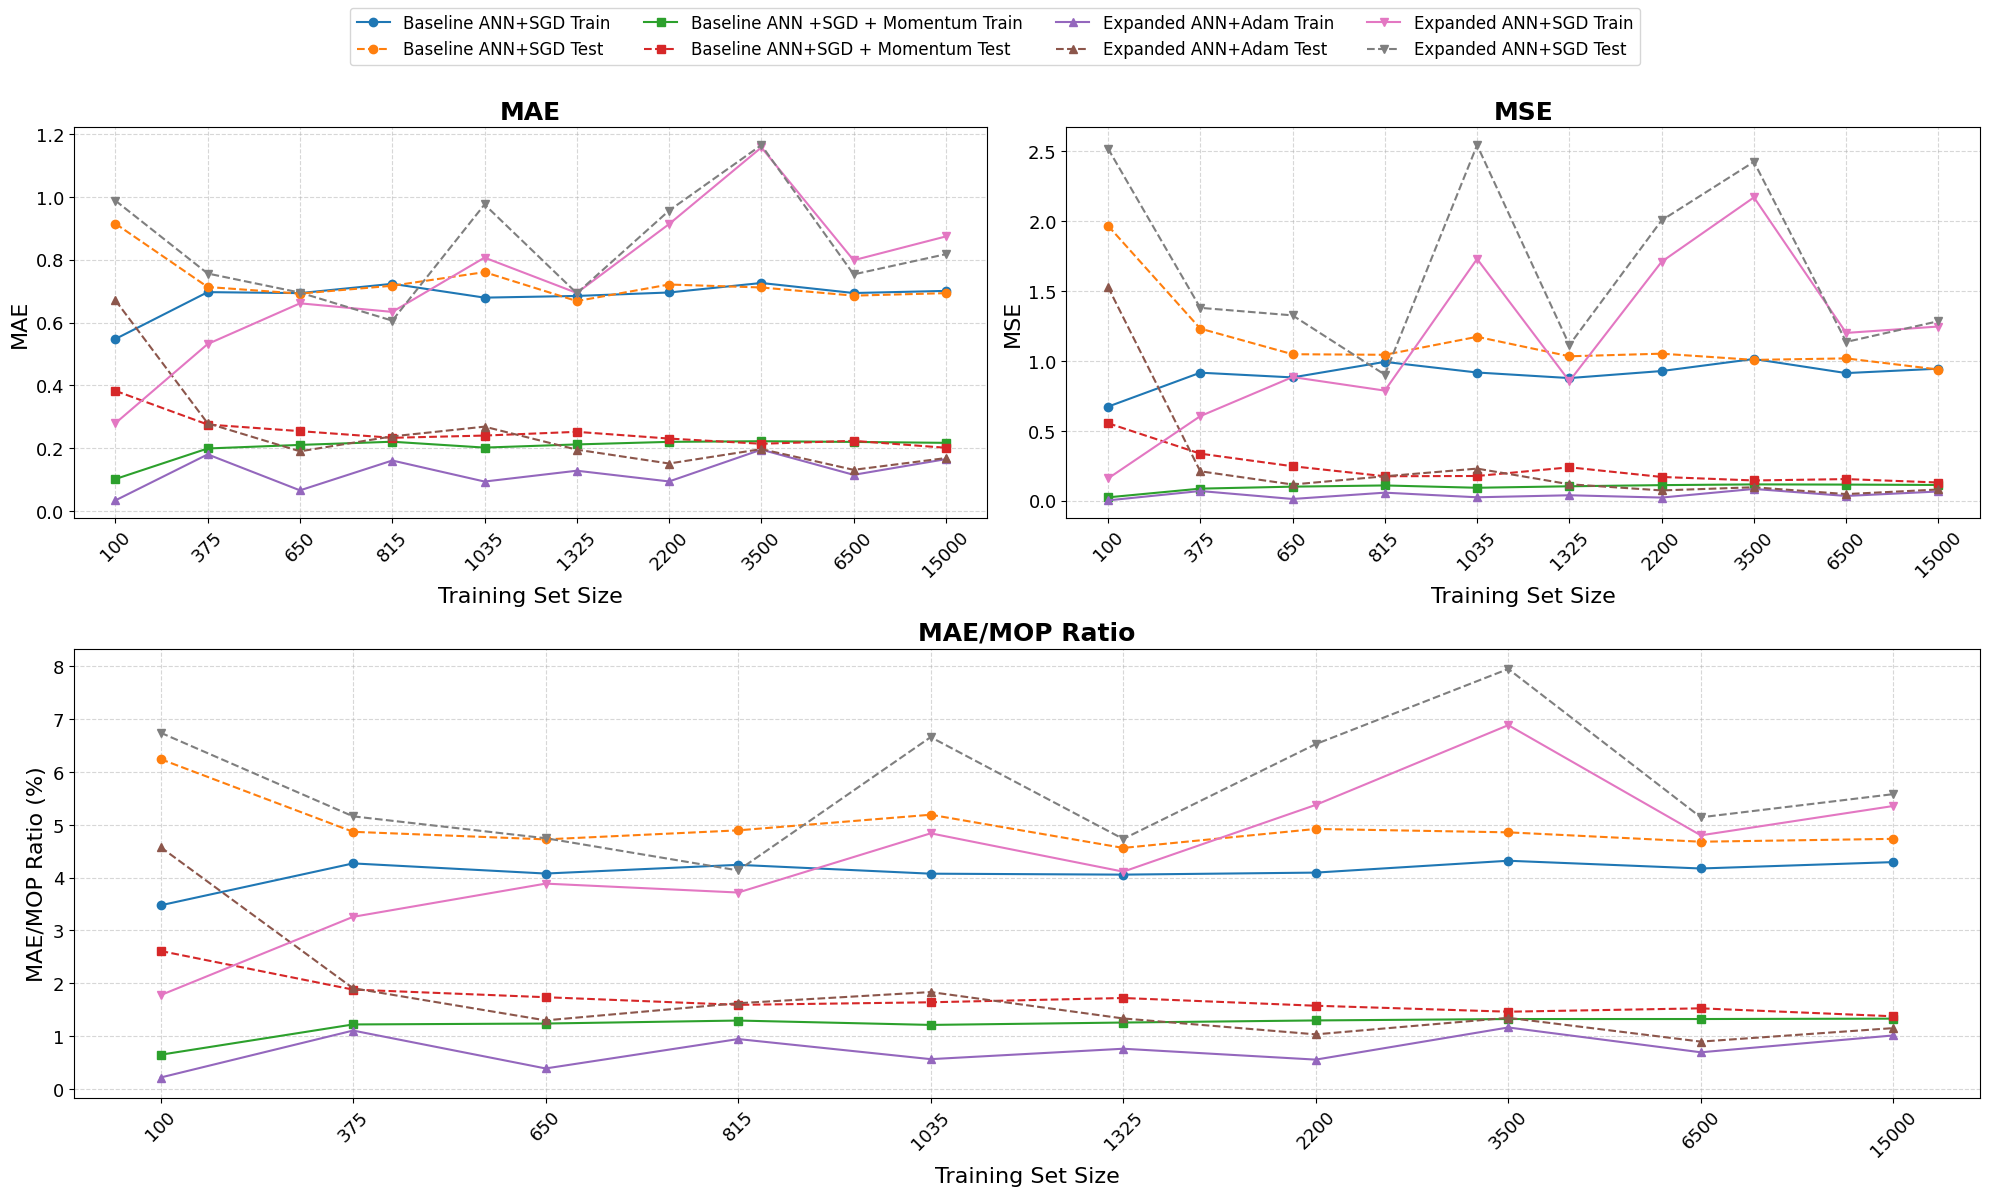

Saved grid plot: Sgd3trainingtesting/Project_1_Metrics_Grid.pdf


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_metric_grid_from_csv(training_sizes, metric_csv_files,
                              metric_names, as_percentage_flags=None,
                              save_dir="Heatmap_Results"):

    os.makedirs(save_dir, exist_ok=True)
    x_vals = list(range(len(training_sizes)))

    if as_percentage_flags is None:
        as_percentage_flags = [False]*len(metric_csv_files)

    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(2, 2, height_ratios=[1, 1.15], figure=fig)
    axes = [
        fig.add_subplot(gs[0, 0]),   # top-left
        fig.add_subplot(gs[0, 1]),   # top-right
        fig.add_subplot(gs[1, :])    # bottom full-width
    ]

    for ax, csv_file, metric_name, as_percentage in zip(axes, metric_csv_files, metric_names, as_percentage_flags):
        # ---- Load CSV ----
        df = pd.read_csv(csv_file, index_col=0)
        df.columns = df.columns.str.strip().tolist()  # clean column names

        # ---- Extract relevant columns ----
        in_train      = df.loc["Baseline ANN + SGD Train", training_sizes].tolist()
        in_test       = df.loc["Baseline ANN + SGD Test", training_sizes].tolist()
        mom_train     = df.loc["Baseline ANN + SGD + Momentum Train", training_sizes].tolist()
        mom_test      = df.loc["Baseline ANN + SGD + Momentum Test", training_sizes].tolist()
        ex_adam_train = df.loc["Expanded ANN + Adam Train", training_sizes].tolist()
        ex_adam_test  = df.loc["Expanded ANN + Adam Test", training_sizes].tolist()
        ex_sgd_train  = df.loc["Expanded ANN + SGD Train", training_sizes].tolist()
        ex_sgd_test   = df.loc["Expanded ANN + SGD Test", training_sizes].tolist()

        # ---- Pad shorter lists if needed ----
        def pad(x): return x + [np.nan]*(len(training_sizes)-len(x)) if len(x) < len(training_sizes) else x
        in_train, in_test, mom_train, mom_test, ex_adam_train, ex_adam_test, ex_sgd_train, ex_sgd_test = map(
            pad, [in_train, in_test, mom_train, mom_test, ex_adam_train, ex_adam_test, ex_sgd_train, ex_sgd_test]
        )

        def repeat_if_single(v): return v * len(training_sizes) if len(v) == 1 else v
        in_test, mom_test, ex_adam_test, ex_sgd_test = map(
            repeat_if_single, [in_test, mom_test, ex_adam_test, ex_sgd_test]
        )

        ax.plot(x_vals, in_train, marker='o', label="Baseline ANN+SGD Train")
        ax.plot(x_vals, in_test, marker='o', linestyle='--', label="Baseline ANN+SGD Test")

        ax.plot(x_vals, mom_train, marker='s', label="Baseline ANN +SGD + Momentum Train")
        ax.plot(x_vals, mom_test, marker='s', linestyle='--', label="Baseline ANN+SGD + Momentum Test")

        ax.plot(x_vals, ex_adam_train, marker='^', label="Expanded ANN+Adam Train")
        ax.plot(x_vals, ex_adam_test, marker='^', linestyle='--', label="Expanded ANN+Adam Test")

        ax.plot(x_vals, ex_sgd_train, marker='v', label="Expanded ANN+SGD Train")
        ax.plot(x_vals, ex_sgd_test, marker='v', linestyle='--', label="Expanded ANN+SGD Test")

        ylabel = metric_name + (" (%)" if as_percentage else "")
        ax.set_title(metric_name, fontsize=18, fontweight='bold')
        ax.set_xlabel("Training Set Size", fontsize=16)
        ax.set_ylabel(ylabel, fontsize=16)
        ax.set_xticks(x_vals)
        ax.set_xticklabels(training_sizes, rotation=45, fontsize=13)
        ax.tick_params(axis='y', labelsize=13)
        ax.grid(True, linestyle='--', alpha=0.5)

    # ---- Global legend ----
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.93])

    filename = os.path.join(save_dir, "Project_1_Metrics_Grid.pdf")
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    plt.show()
    plt.close()

    print(f"Saved grid plot: {filename}")


metric_csv_files = [
    "Heatmap_Results/Project_1_MeanAbsoluteErrorMAEUSD_metrics.csv",
    "Heatmap_Results/Project_1_MeanSquaredErrorMSE_metrics.csv",
    "Heatmap_Results/Project_1_MAEMeanOptionPrice_metrics.csv"
]

plot_metric_grid_from_csv(
    training_sizes,
    metric_csv_files,
    metric_names=["MAE", "MSE", "MAE/MOP Ratio"],
    as_percentage_flags=[False, False, True]  
)
